# Transforming SDFGs

In this tutorial we will use the graph transformation (rewriting) capabilities of DaCe to apply _strict transformations_, which will enable applying performance-optimizing transformations. We will use both the SDFG API and the transformation Console UI.

Another option is to use **DIODE**, the interactive optimization IDE, which is not covered in this tutorial. For more information, see the [tutorial video](https://www.vimeo.com/301317247).

In [1]:
import dace as dc

## Strict Transformations

Below we see a matrix multiplication in its declarative form in the DaCe explicit interface, and the resulting SDFG:

In [2]:
M = dc.symbol('M')
N = dc.symbol('N')
K = dc.symbol('K')

@dc.program
def mm(A: dc.float32[M, K], B: dc.float32[K, N], C: dc.float32[M, N]):
    tmp = dc.define_local([M, N, K], dc.float32)
    
    @dc.map
    def multiply(i: _[0:M], j: _[0:N], k: _[0:K]):
        a << A[i, k]
        b << B[k, j]
        t >> tmp[i, j, k]
        
        t = a * b
        
    dc.reduce(lambda a,b: a+b, tmp, C, axis=2, identity=0)

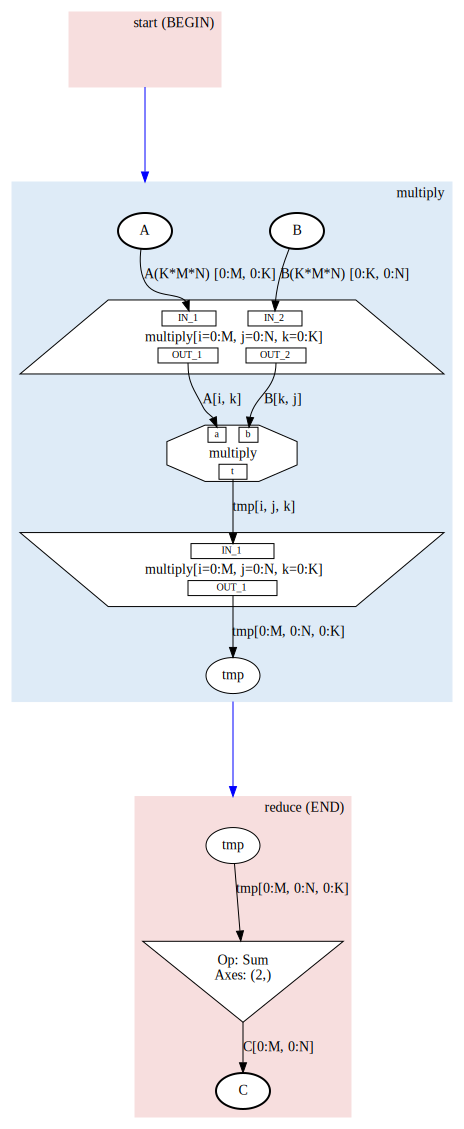

In [3]:
sdfg = mm.to_sdfg(strict=False)
sdfg

Notice the `strict=False`. By default, DaCe applies strict (correctness-preserving) transformations on SDFGs generated from implicit/explicit dataflow in Python. These transformations include fusing states when there are no hazards (`StateFusion`), and removing unnecessary transient Data nodes. In the above example, we disabled it to show that DaCe actually generates three states. We will now apply strict transformations separately on the SDFG and show the (more compact) result.

Automatically applied 2 strict state fusions and removed 0 redundant arrays.


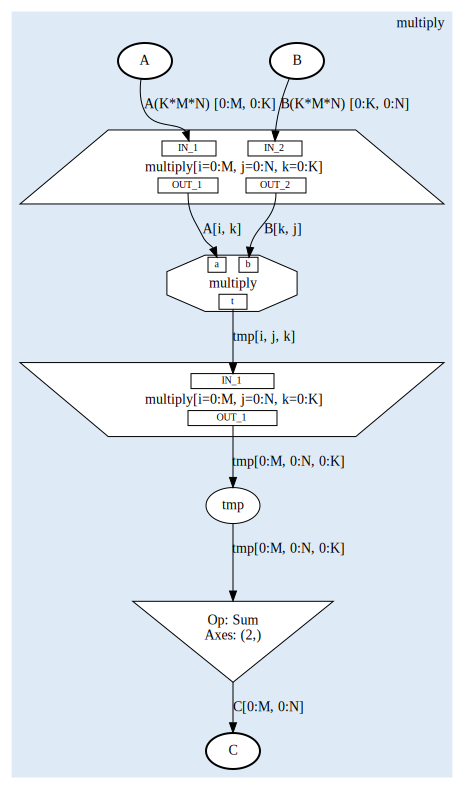

In [4]:
sdfg.apply_strict_transformations()
sdfg

## Transforming SDFGs using the Console UI

When invoking SDFGs, the usual behavior (defined in the configuration `optimizer.interface`) is to run the SDFG console optimizer (`dace.transformation.optimizer.SDFGOptimizer`). This is the component responsible for printing the matched transformations and receiving console input.

If the "Enter" key is pressed, the SDFG is no longer transformed and is sent to code generation. We will now enable profiling and test the performance of the above matrix multiplication SDFG as-is, and after a transformation fusing the map scope with the reduce node. _Note that this transformation would not have been matched if not for the strict state fusion performed above._

In [5]:
dc.Config.set('profiling', value=True)

import numpy as np
A = np.random.rand(256, 255).astype(np.float32)
B = np.random.rand(255, 254).astype(np.float32)
C = np.random.rand(256, 254).astype(np.float32)

Without transformations:

In [6]:
sdfg(A=A, B=B, C=C, M=256, K=255, N=254)

0. Pattern FPGATransformSDFG in mm
1. Pattern FPGATransformState in multiply
2. Pattern GPUTransformSDFG in mm
3. Pattern NestSDFG in mm
4. Pattern FPGATransformMap in multiply[i=0:M, j=0:N, k=0:K]
5. Pattern GPUTransformLocalStorage in multiply[i=0:M, j=0:N, k=0:K]
6. Pattern GPUTransformLocalStorage in Op: Sum, Axes: (2,)
7. Pattern GPUTransformMap in multiply[i=0:M, j=0:N, k=0:K]
8. Pattern GPUTransformMap in Op: Sum, Axes: (2,)
9. Pattern MapExpansion in multiply: ['i', 'j', 'k']
10. Pattern MapReduceFusion in 3 -> 4 -> 5
11. Pattern OrthogonalTiling in multiply: ['i', 'j', 'k']
12. Pattern ReduceExpansion in Op: Sum, Axes: (2,): (lambda a, b: (a + b)) on (2,)
13. Pattern StripMining in multiply: ['i', 'j', 'k']
Select the pattern to apply (0 - 13 or name$id): 
You did not select a valid option. Quitting optimization ...
-- Configuring done
-- Generating done
-- Build files have been written to: /path/to/dace/tutorials/.dacecache/mm/build

[ 50%] Built target dacestub
Scanning depe

After the `MapReduceFusion` transformation:

In [7]:
sdfg(A=A, B=B, C=C, M=256, K=255, N=254)

0. Pattern FPGATransformSDFG in mm
1. Pattern FPGATransformState in multiply
2. Pattern GPUTransformSDFG in mm
3. Pattern NestSDFG in mm
4. Pattern FPGATransformMap in multiply[i=0:M, j=0:N, k=0:K]
5. Pattern GPUTransformLocalStorage in multiply[i=0:M, j=0:N, k=0:K]
6. Pattern GPUTransformLocalStorage in Op: Sum, Axes: (2,)
7. Pattern GPUTransformMap in multiply[i=0:M, j=0:N, k=0:K]
8. Pattern GPUTransformMap in Op: Sum, Axes: (2,)
9. Pattern MapExpansion in multiply: ['i', 'j', 'k']
10. Pattern MapReduceFusion in 3 -> 4 -> 5
11. Pattern OrthogonalTiling in multiply: ['i', 'j', 'k']
12. Pattern ReduceExpansion in Op: Sum, Axes: (2,): (lambda a, b: (a + b)) on (2,)
13. Pattern StripMining in multiply: ['i', 'j', 'k']
Select the pattern to apply (0 - 13 or name$id): MapReduceFusion$0
You selected (MapReduceFusion$0) pattern MapReduceFusion in 3 -> 4 -> 5 with parameters {}
0. Pattern FPGATransformSDFG in mm
1. Pattern FPGATransformState in multiply
2. Pattern GPUTransformSDFG in mm
3. Pa

Notice how the time has decreased from 73.39 ms to 28.84 ms. 

We can also inspect the transformed SDFG by compiling it separately from its invocation and obtaining the resulting SDFG:

0. Pattern FPGATransformSDFG in mm
1. Pattern FPGATransformState in multiply
2. Pattern GPUTransformSDFG in mm
3. Pattern NestSDFG in mm
4. Pattern FPGATransformMap in multiply[i=0:M, j=0:N, k=0:K]
5. Pattern GPUTransformLocalStorage in multiply[i=0:M, j=0:N, k=0:K]
6. Pattern GPUTransformLocalStorage in Op: Sum, Axes: (2,)
7. Pattern GPUTransformMap in multiply[i=0:M, j=0:N, k=0:K]
8. Pattern GPUTransformMap in Op: Sum, Axes: (2,)
9. Pattern MapExpansion in multiply: ['i', 'j', 'k']
10. Pattern MapReduceFusion in 3 -> 4 -> 5
11. Pattern OrthogonalTiling in multiply: ['i', 'j', 'k']
12. Pattern ReduceExpansion in Op: Sum, Axes: (2,): (lambda a, b: (a + b)) on (2,)
13. Pattern StripMining in multiply: ['i', 'j', 'k']
Select the pattern to apply (0 - 13 or name$id): MapReduceFusion$0
You selected (MapReduceFusion$0) pattern MapReduceFusion in 3 -> 4 -> 5 with parameters {}
0. Pattern FPGATransformSDFG in mm
1. Pattern FPGATransformState in multiply
2. Pattern GPUTransformSDFG in mm
3. Pa

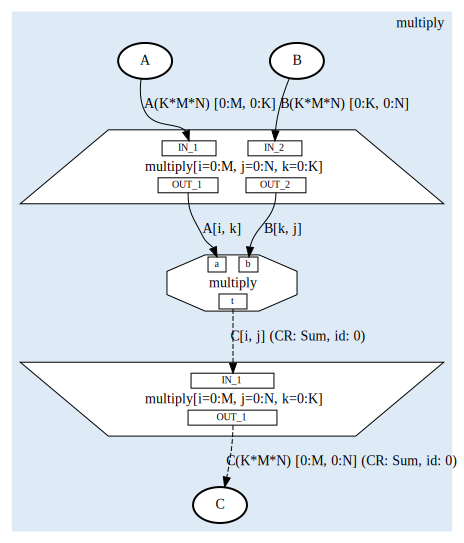

In [8]:
compiled_sdfg = sdfg.compile()
compiled_sdfg.sdfg

## Manually Transforming an SDFG

Another option would be to use the SDFG API directly to transform an SDFG. Below we write a simple snippet that matches the first `MapReduceFusion` and applies it to the above SDFG:

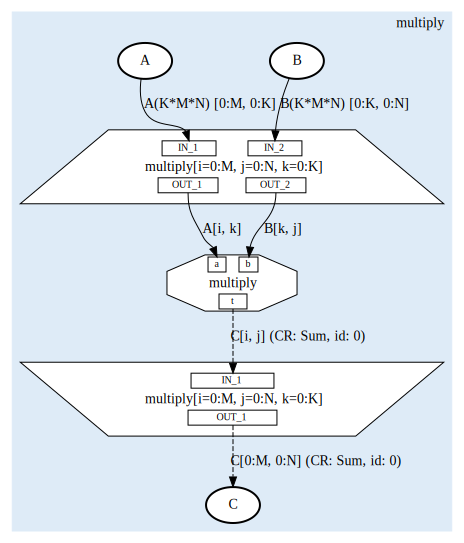

In [9]:
from dace.transformation import optimizer
from dace.transformation.dataflow import MapReduceFusion

# Create an SDFG optimizer
opt = optimizer.SDFGOptimizer(sdfg, inplace=True)

# Find all matches for MapReduceFusion and apply them
for match in opt.get_pattern_matches(patterns=[MapReduceFusion]):
    match.apply(sdfg)
    
# Display resulting SDFG
sdfg

As we can see above, the resulting SDFG is equivalent to the one created in the previous section.